In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("/data/tim/heronWorkspace/src")
sys.path.append("/data/tim/heronWorkspace/0_preProcessing")
sys.path.append("/data/tim/heronWorkspace/1_AE")
sys.path.append("/data/tim/heronWorkspace/2_postProcessing")


from AEHeronModel import CAEHeron
import HeronImageLoader
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
import pandas as pd
from models import CAEV1
import numpy as np
import torch.nn.functional as F
import torch
from torchvision.transforms import GaussianBlur
from PIL import Image, ImageFilter
from ClassifierDatasets import DatasetThreeConsecutive
from skimage.metrics import structural_similarity as ssim
import seaborn as sns
from PostProcessingHelper import CheckPoints
sns.set_theme()
colors = [
    "#32829C",
    "#E38538",
    "#51AC8C",
    "#D94841",
    "#7A5C96"
]
sns.set_palette(sns.color_palette(colors))
sns.set_style("whitegrid")

In [14]:
from matplotlib import rcParams
rcParams['patch.linewidth'] = 0.5

def plotAndHistArr(arr : np.array, vmin, vmax):
    norm = plt.Normalize(vmin=vmin, vmax=vmax)
    f, a = plt.subplots(2,len(arr), figsize=(len(arr) * 10, 17))

    for i in range(len(arr)):
        a[0, i].imshow(arr[i], cmap = "hot", interpolation='none', norm=norm)
        a[1, i].hist(arr[i].flatten(), bins=100, range=(0, 1), color=sns.color_palette()[0])
        
        a[0, i].grid(False)
        a[0, i].xaxis.set_visible(False)
        a[0, i].yaxis.set_visible(False)
        a[0, i].text(0.5,-0.3, f'sum: {np.sum(arr[i]):.2f}', size=30, ha="center", transform=a[0, i].transAxes)

        a[1][i].set_ylim([0,2000])
        a[1][i].set_xlim([0,1])
        a[1, i].tick_params(axis="x", labelsize=15)
        a[1, i].tick_params(axis="y", labelsize=15)

    

In [3]:
checkPoint = '/data/tim/heronWorkspace/logs/CAEV1/version_3/checkpoints/epoch=49-step=19350.ckpt'
checkPointGlobal = "/data/tim/heronWorkspace/logs/BasicCAE1/version_5/checkpoints/epoch=14-step=20385.ckpt"
checkPointSBU3 = "/data/tim/heronWorkspace/logs/BasicCAE1/version_12/checkpoints/epoch=24-step=4825.ckpt"
checkPointSBU3Better = "/data/tim/heronWorkspace/logs/BasicCAE1SBU3/version_0/checkpoints/epoch=48-step=9457.ckpt"

caeLoaded = CAEHeron.load_from_checkpoint(checkPoint, model = CAEV1)
caeLoaded.freeze()
print(caeLoaded.hparams)

dataset = DatasetThreeConsecutive(set="paper", resize_to=CAEV1.imsize, cameras=caeLoaded.hparams.cameras)
dataLoader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=4)
print(f'Length Dataset: {len(dataLoader.dataset.imagePaths)}')
unnorm = HeronImageLoader.UnNormalize()

blur = GaussianBlur(kernel_size=5, sigma=3)
lossFn = F.l1_loss

"batch_size":         16
"bottleneck":         128
"cameras":            ['NEN1', 'SBU3']
"gammaScheduler":     0.7879353477950641
"ldim":               16
"learning_rate":      0.003533238255084643
"num_workers_loader": 4
"transforms":         None
"weight_decay":       4.5387898639621974e-07
Length Dataset: 4


In [4]:
def minFilter(tensor : torch.Tensor, kernel_size=3):
    # Unfold the tensor into sliding local blocks
    unfolded = tensor.unfold(0, kernel_size, 1)
    unfolded = unfolded.unfold(1, kernel_size, 1)
    # Compute the minimum in each of these blocks
    return unfolded.min(dim=-1)[0].min(dim=-1)[0]

## img with it's reconstruction

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


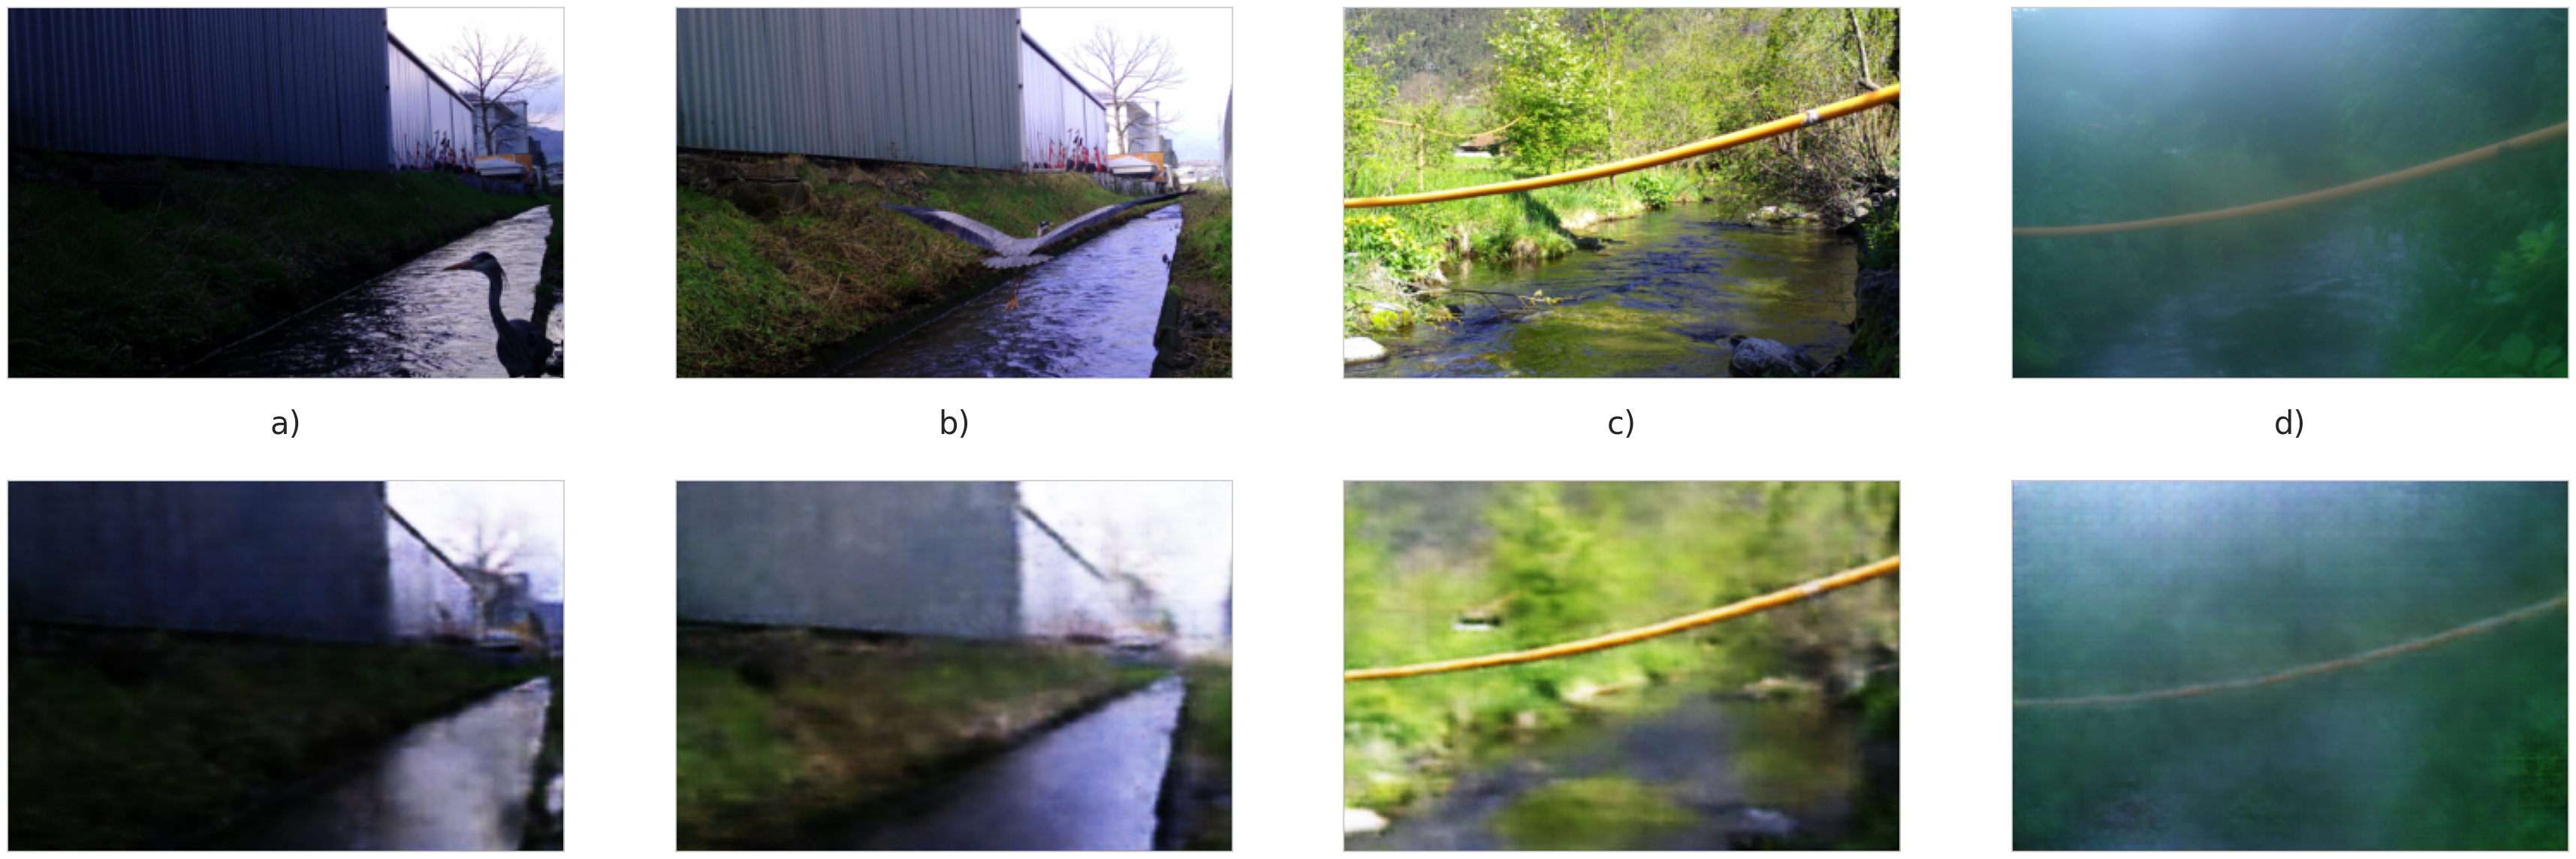

In [5]:


allImg = []
allPred = []
for i, (imArr, lblArr, camera, ImagePath) in enumerate(dataLoader):
            isTrainingCamera = camera in caeLoaded.hparams.cameras
            prevImg = imArr[0] #alwasy #batch_size images
            currImg = imArr[1]
            nextImg = imArr[2]

            prevPred, currPred, nextPred = [unnorm(caeLoaded(x.to(caeLoaded.device))) for x in [prevImg, currImg, nextImg]]
            allPred.append(currPred)

            prevImg, currImg, nextImg = [unnorm(x) for x in [prevImg, currImg, nextImg]]
            allImg.append(currImg)

            # prevImgBlurred, currImgBlurred, nextImgBlurred = [blur.forward(x).to(prevPred.device) for x in [prevImg, currImg, nextImg]]
        
            
            # prevImd, currImd, nextImd = [torch.sum(lossFn(imgBlurred, pred, reduction='none'), dim=1) for imgBlurred, pred in zip([prevImgBlurred, currImgBlurred, nextImgBlurred], [prevPred, currPred, nextPred])]

            # prevToCurrImd = torch.clamp(torch.sub(currImd, prevImd), min= 0)
            # nextToCurrImd = torch.clamp(torch.sub(currImd, nextImd), min= 0)

            # prevNextCurrImd = torch.div(torch.add(prevToCurrImd, nextToCurrImd), 2)

            # prevNextCurrImdMin = torch.stack([minFilter(x, kernel_size=3) for x in prevNextCurrImd]) #TODO: evtl make this as before
            

            # prevNextCurrImdMinThresh = torch.where(prevNextCurrImdMin < params["zeroThreshold"], torch.zeros_like(prevNextCurrImdMin), prevNextCurrImdMin)
            

            # sumPrevNextCurrImdMin = torch.sum(prevNextCurrImdMinThresh, dim=(1, 2))
            # predictions = (sumPrevNextCurrImdMin> params["sumThreshold"]).to(torch.int)

f, a = plt.subplots(2,len(dataLoader), figsize=(len(dataLoader) * 11,15))
for i in range(len(dataLoader)):
    a[0, i].imshow(allImg[i][0].permute(1,2,0).cpu())
    a[1, i].imshow(allPred[i][0].permute(1,2,0).cpu())
    
    a[0, i].grid(False)
    a[1, i].grid(False)

    a[0, i].xaxis.set_visible(False)
    a[0, i].yaxis.set_visible(False)
    a[1, i].xaxis.set_visible(False)
    a[1, i].yaxis.set_visible(False)

    a[0, i].text(0.5,-0.15, f'{chr(i + ord("a"))})', size=30, ha="center", transform=a[0, i].transAxes)

# f.text(0, 0, 'Ground Truth', ha='center', va="center" , fontsize=40, transform=f.transFigure)
# plt.tight_layout()
plt.show()

## difference pred to img with hist
without blur

1.8650363683700562
1.5069780349731445
1.8742883205413818
0.5861319899559021


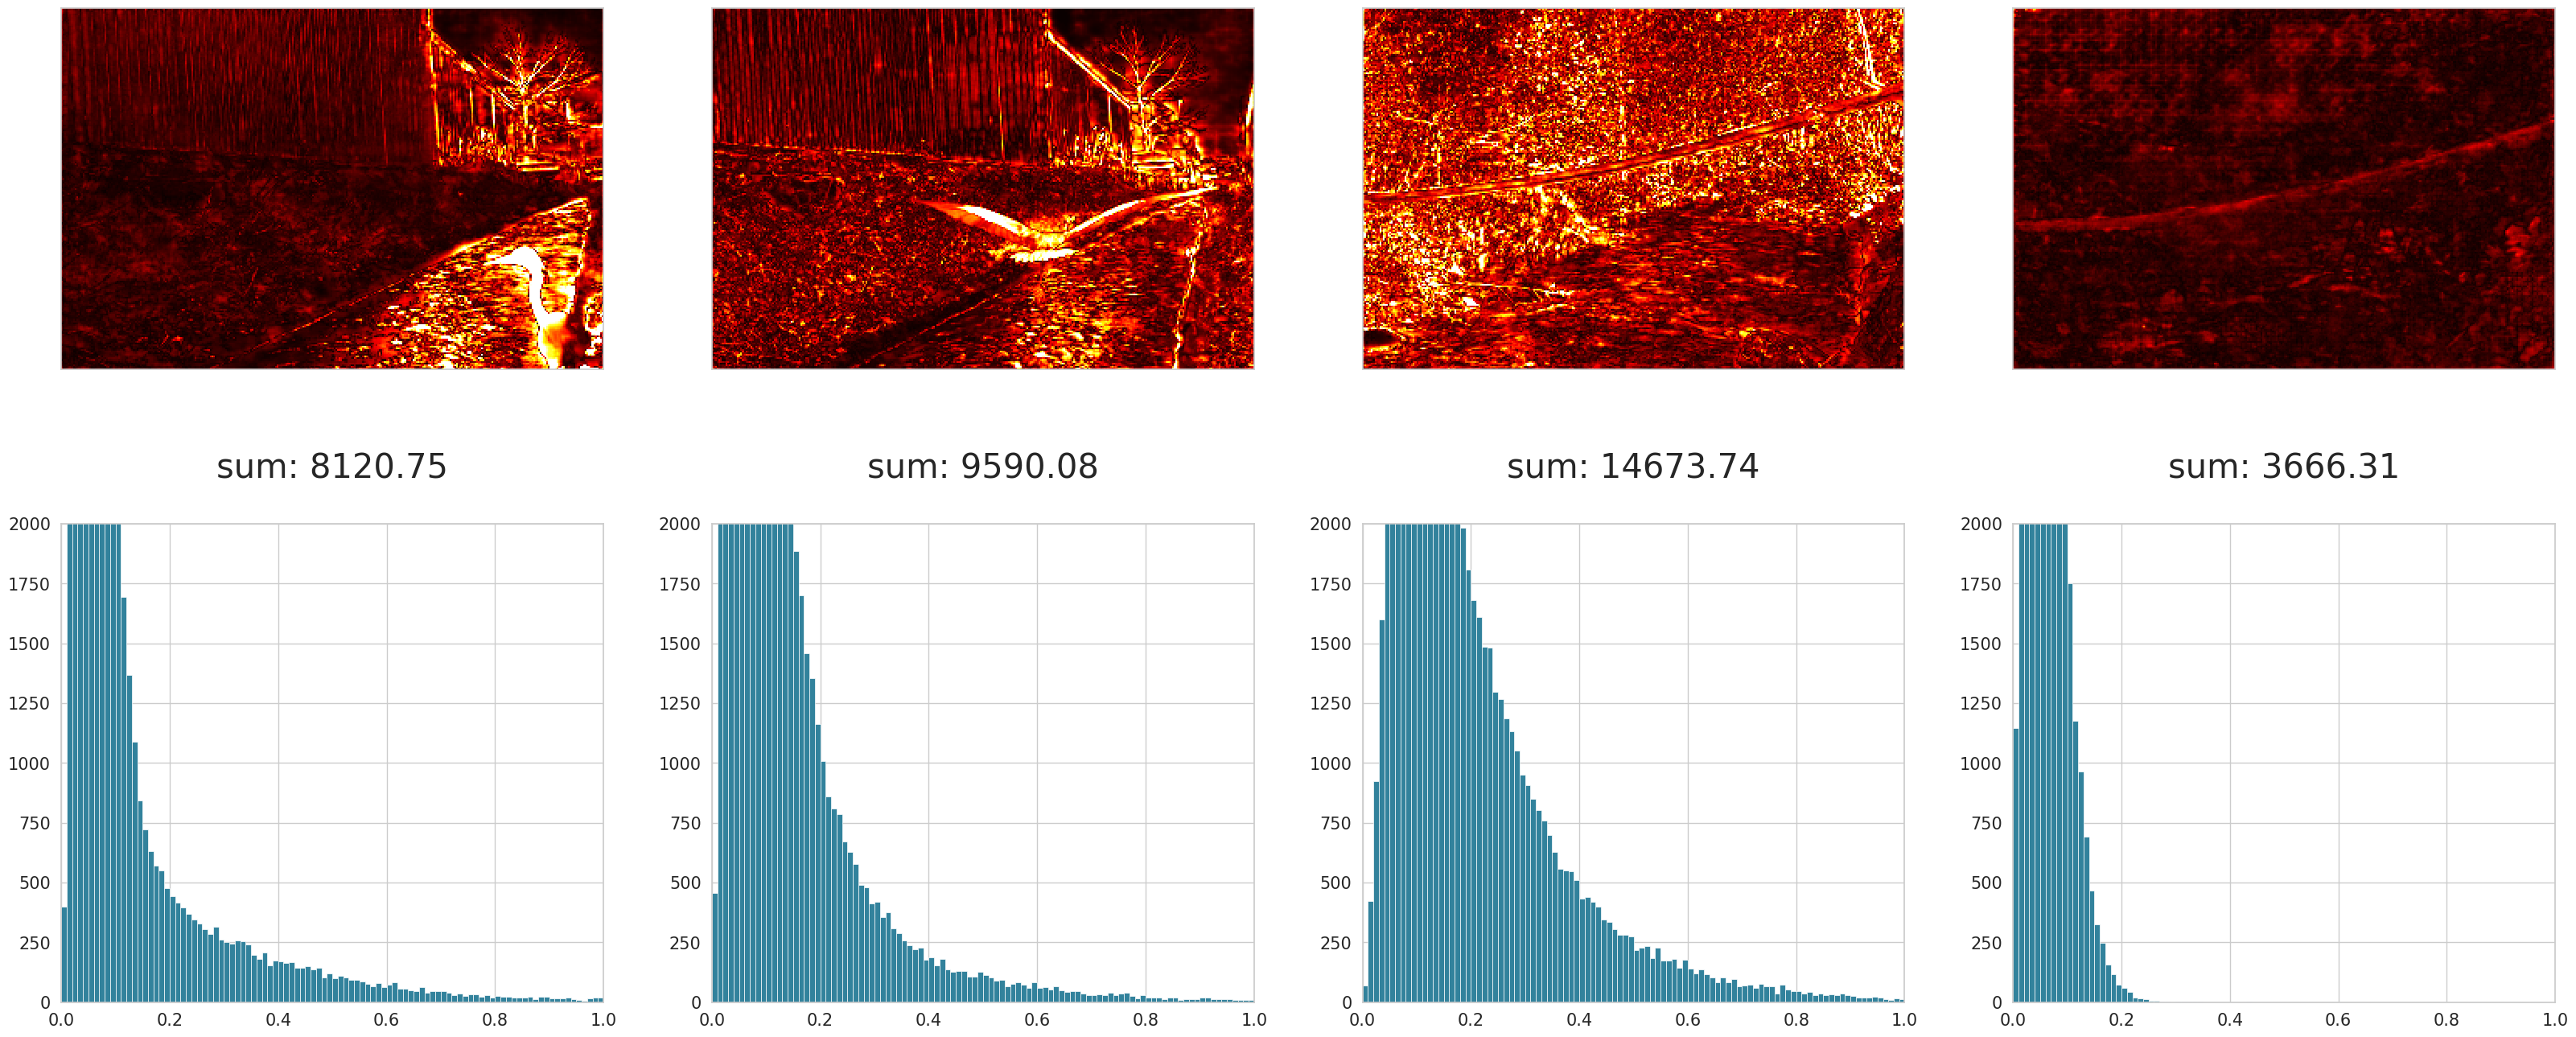

In [15]:
allImd = []
for i, (imArr, lblArr, camera, ImagePath) in enumerate(dataLoader):
            isTrainingCamera = camera in caeLoaded.hparams.cameras
            prevImg = imArr[0] #alwasy #batch_size images
            currImg = imArr[1]
            nextImg = imArr[2]

            prevPred, currPred, nextPred = [unnorm(caeLoaded(x.to(caeLoaded.device))) for x in [prevImg, currImg, nextImg]]
            allPred.append(currPred)

            prevImg, currImg, nextImg = [unnorm(x) for x in [prevImg, currImg, nextImg]]
            allImg.append(currImg)

            prevImgBlurred, currImgBlurred, nextImgBlurred = [x.to(prevPred.device) for x in [prevImg, currImg, nextImg]]
            
            
            prevImd, currImd, nextImd = [torch.sum(lossFn(imgBlurred, pred, reduction='none'), dim=1) for imgBlurred, pred in zip([prevImgBlurred, currImgBlurred, nextImgBlurred], [prevPred, currPred, nextPred])]
            print(currImd[0].max().item())
            allImd.append(currImd[0].cpu().numpy())

            # prevToCurrImd = torch.clamp(torch.sub(currImd, prevImd), min= 0)
            # nextToCurrImd = torch.clamp(torch.sub(currImd, nextImd), min= 0)

            # prevNextCurrImd = torch.div(torch.add(prevToCurrImd, nextToCurrImd), 2)

            # prevNextCurrImdMin = torch.stack([minFilter(x, kernel_size=3) for x in prevNextCurrImd]) #TODO: evtl make this as before
            

            # prevNextCurrImdMinThresh = torch.where(prevNextCurrImdMin < params["zeroThreshold"], torch.zeros_like(prevNextCurrImdMin), prevNextCurrImdMin)
            

            # sumPrevNextCurrImdMin = torch.sum(prevNextCurrImdMinThresh, dim=(1, 2))
            # predictions = (sumPrevNextCurrImdMin> params["sumThreshold"]).to(torch.int)


plotAndHistArr(allImd, 0, 0.7)


## difference pred to img with hist with gaussianfilter

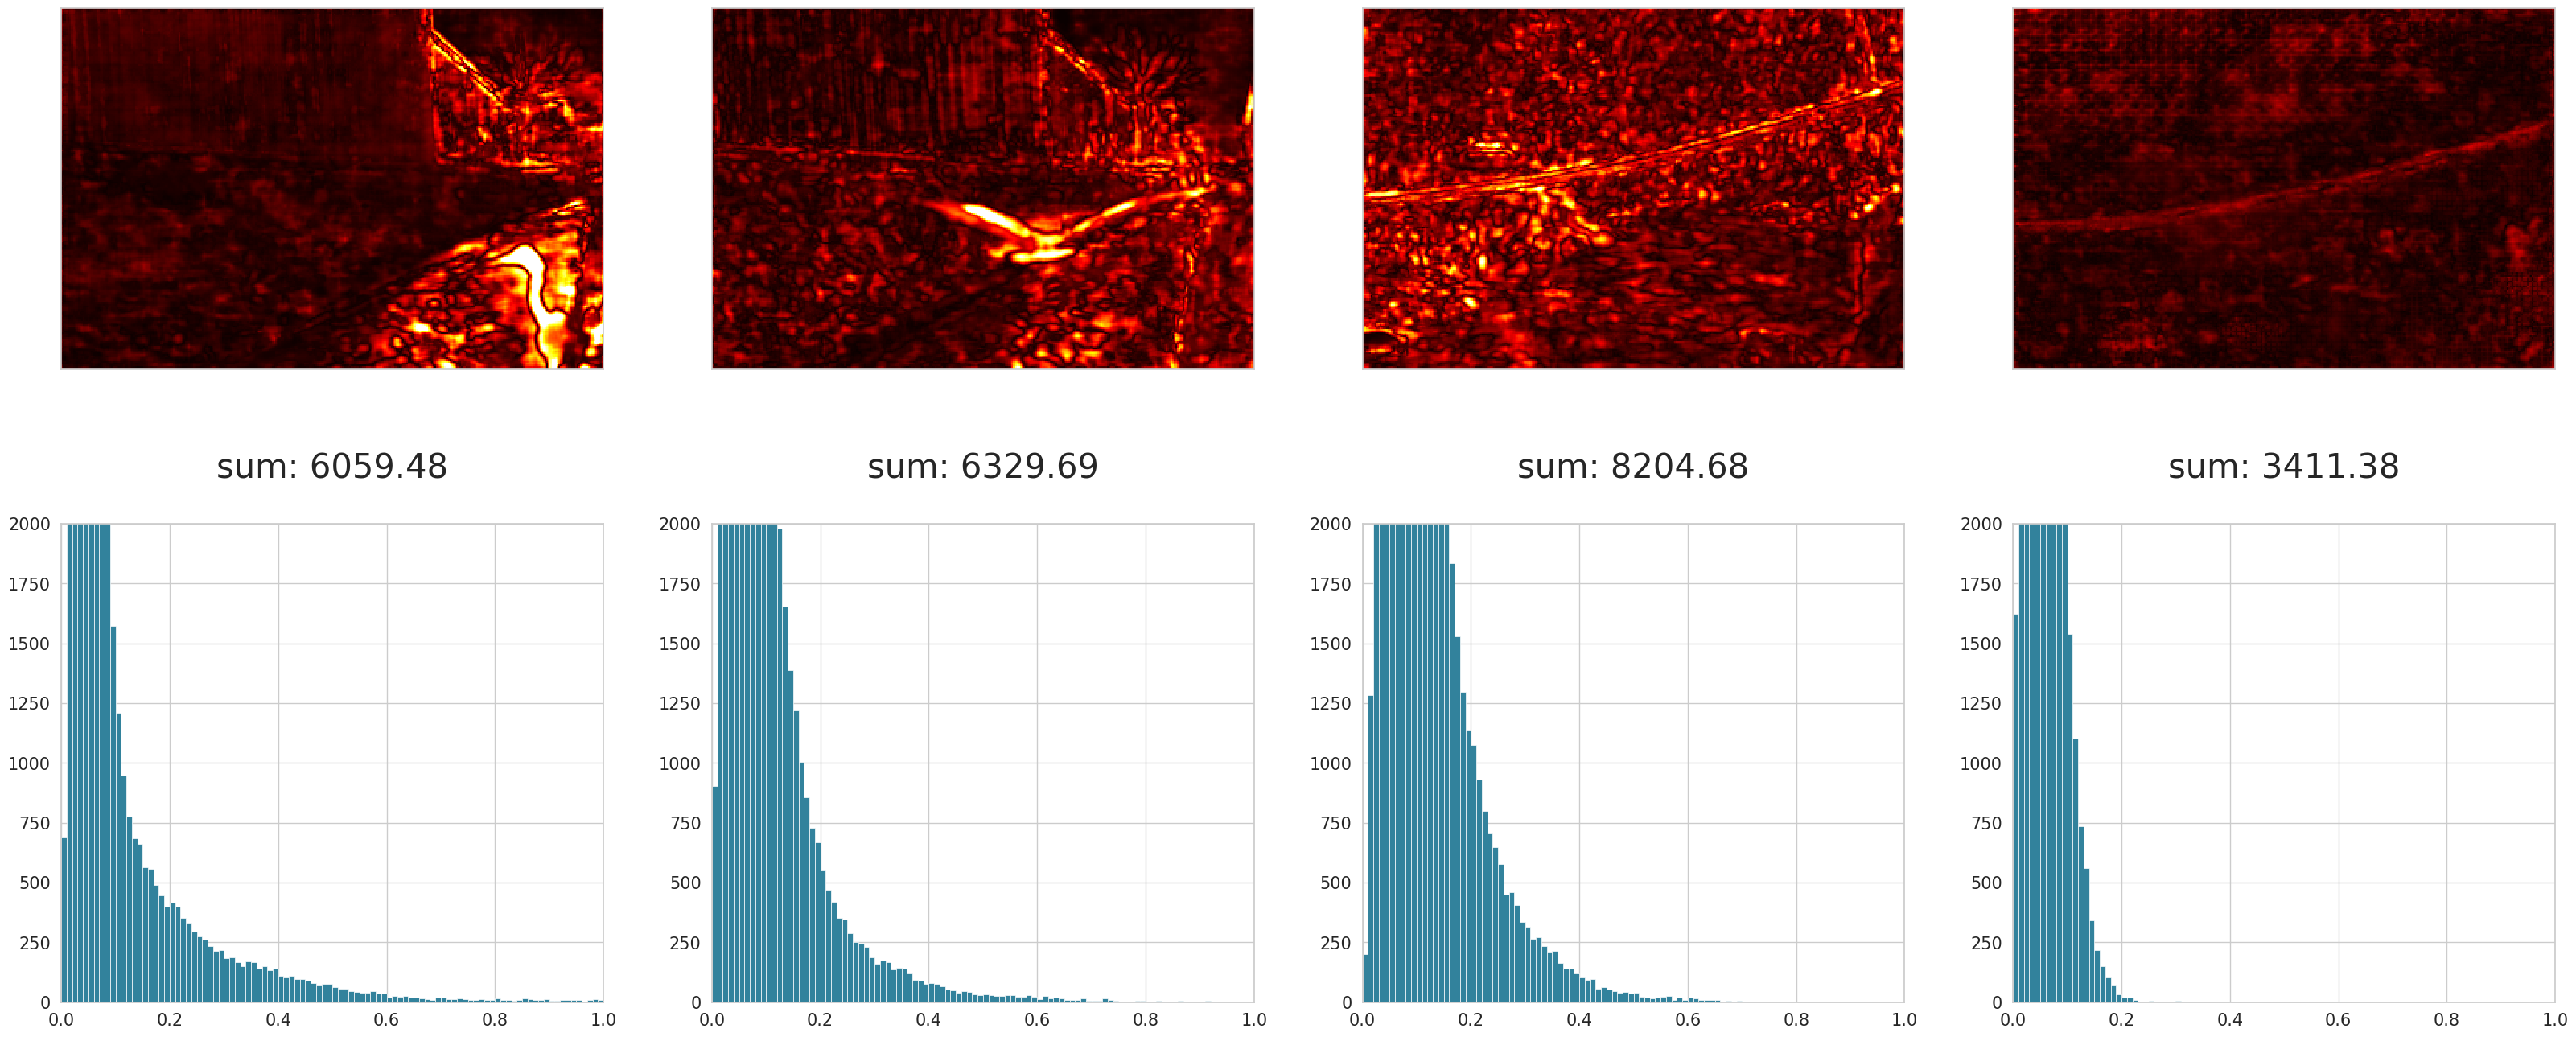

In [16]:
blur = GaussianBlur(kernel_size=5, sigma=5)

allImd = []
for i, (imArr, lblArr, camera, ImagePath) in enumerate(dataLoader):
            isTrainingCamera = camera in caeLoaded.hparams.cameras
            prevImg = imArr[0] #alwasy #batch_size images
            currImg = imArr[1]
            nextImg = imArr[2]

            prevPred, currPred, nextPred = [unnorm(caeLoaded(x.to(caeLoaded.device))) for x in [prevImg, currImg, nextImg]]
            allPred.append(currPred)

            prevImg, currImg, nextImg = [unnorm(x) for x in [prevImg, currImg, nextImg]]
            allImg.append(currImg)

            prevImgBlurred, currImgBlurred, nextImgBlurred = [blur.forward(x).to(prevPred.device) for x in [prevImg, currImg, nextImg]]
            
            
            prevImd, currImd, nextImd = [torch.sum(lossFn(imgBlurred, pred, reduction='none'), dim=1) for imgBlurred, pred in zip([prevImgBlurred, currImgBlurred, nextImgBlurred], [prevPred, currPred, nextPred])]
            allImd.append(currImd[0].cpu().numpy())

            # prevToCurrImd = torch.clamp(torch.sub(currImd, prevImd), min= 0)
            # nextToCurrImd = torch.clamp(torch.sub(currImd, nextImd), min= 0)

            # prevNextCurrImd = torch.div(torch.add(prevToCurrImd, nextToCurrImd), 2)

            # prevNextCurrImdMin = torch.stack([minFilter(x, kernel_size=3) for x in prevNextCurrImd]) #TODO: evtl make this as before
            

            # prevNextCurrImdMinThresh = torch.where(prevNextCurrImdMin < params["zeroThreshold"], torch.zeros_like(prevNextCurrImdMin), prevNextCurrImdMin)
            

            # sumPrevNextCurrImdMin = torch.sum(prevNextCurrImdMinThresh, dim=(1, 2))
            # predictions = (sumPrevNextCurrImdMin> params["sumThreshold"]).to(torch.int)


plotAndHistArr(allImd, 0, 0.7)


# difference previous to current

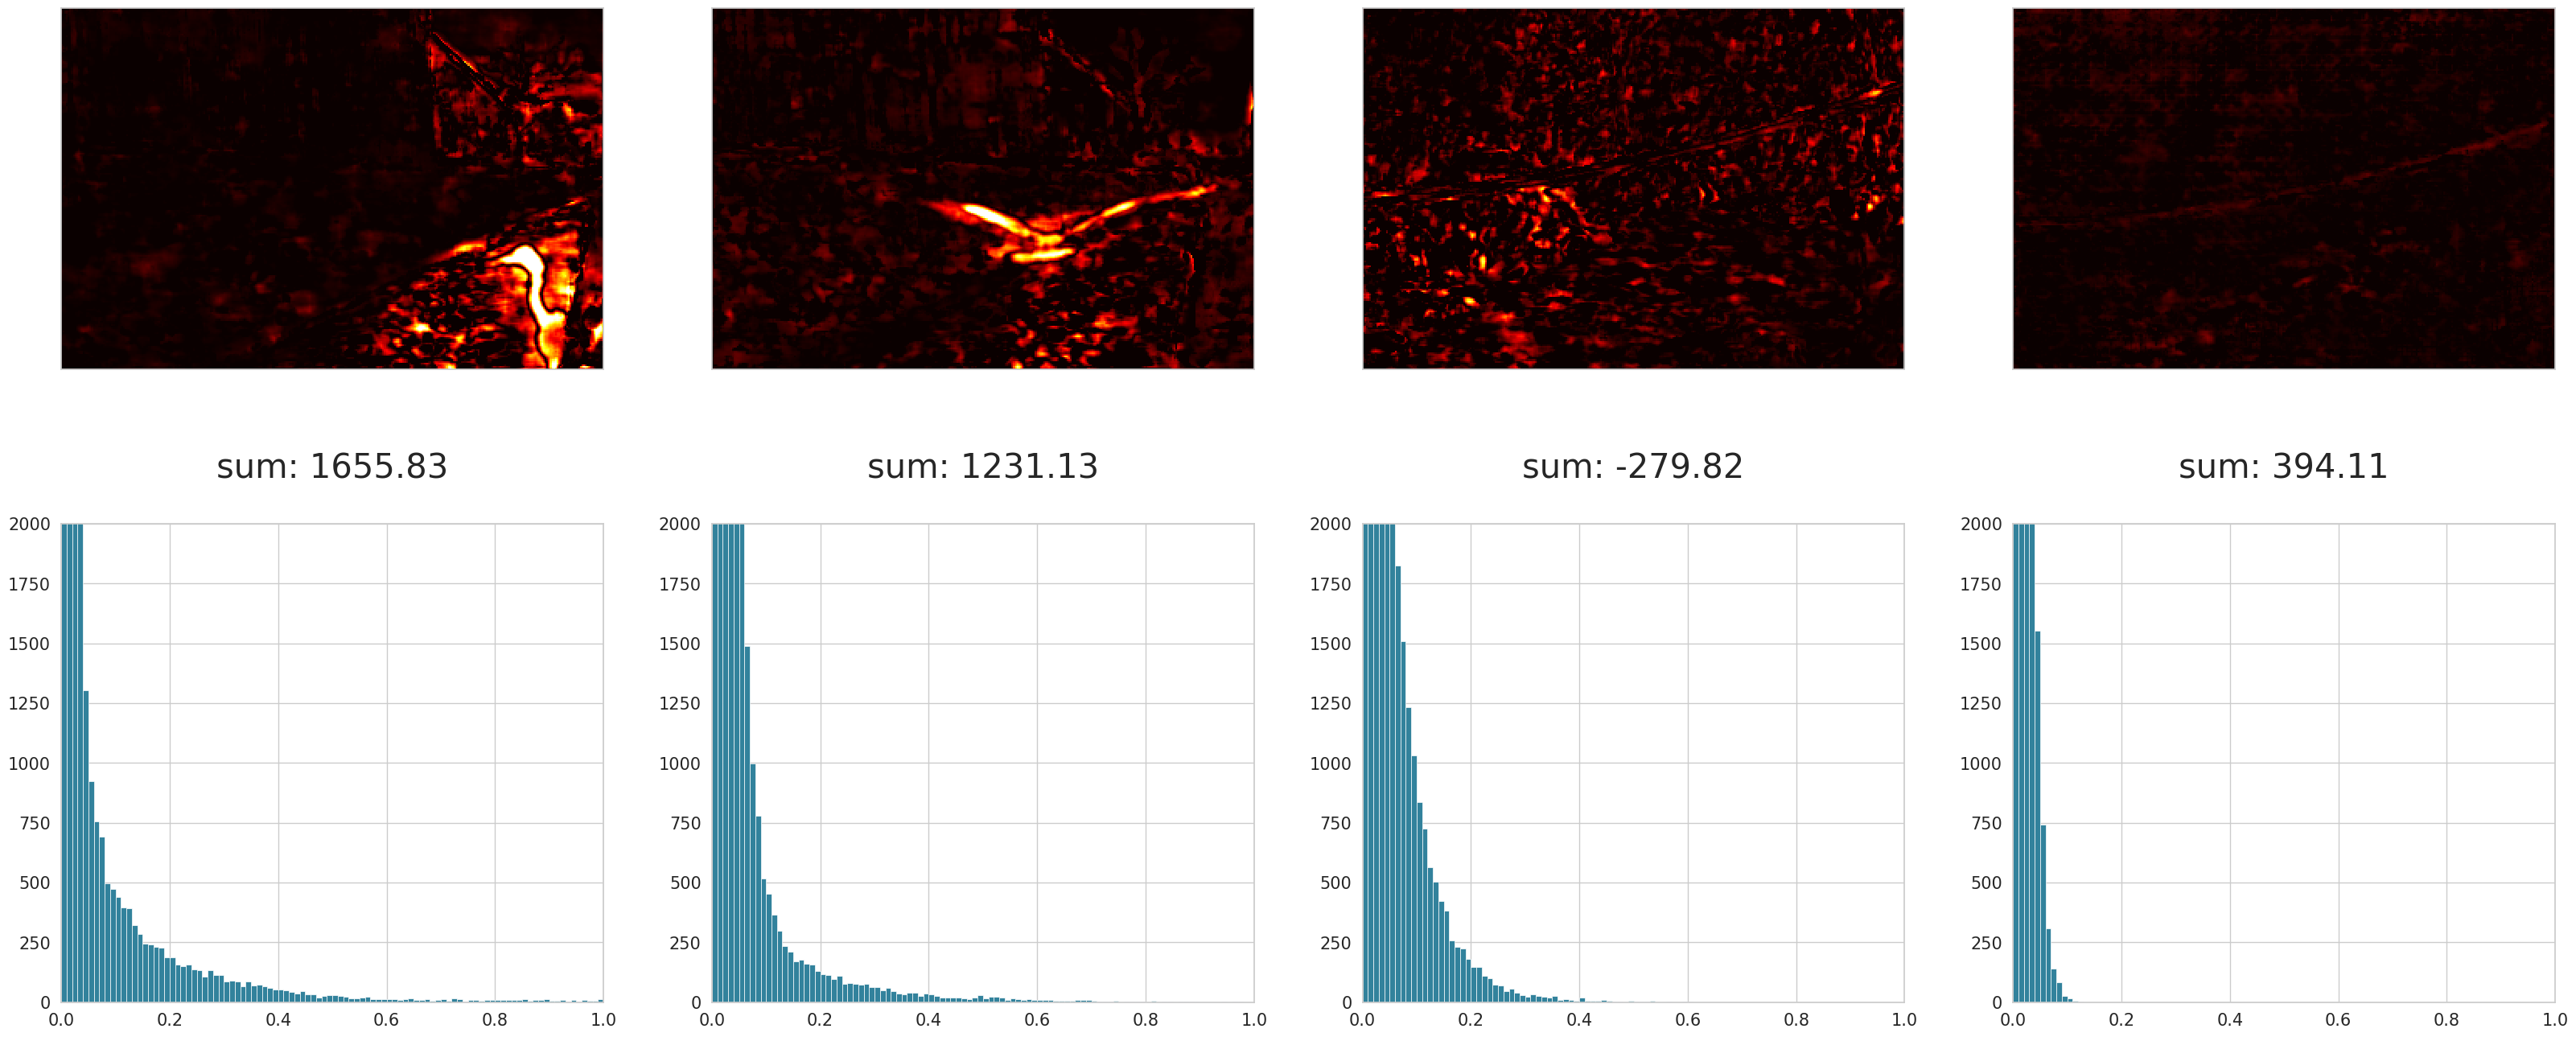

In [17]:
blur = GaussianBlur(kernel_size=5, sigma=5)

allPrevToCurrImd = []
for i, (imArr, lblArr, camera, ImagePath) in enumerate(dataLoader):
            isTrainingCamera = camera in caeLoaded.hparams.cameras
            prevImg = imArr[0] #alwasy #batch_size images
            currImg = imArr[1]
            nextImg = imArr[2]

            prevPred, currPred, nextPred = [unnorm(caeLoaded(x.to(caeLoaded.device))) for x in [prevImg, currImg, nextImg]]
            allPred.append(currPred)

            prevImg, currImg, nextImg = [unnorm(x) for x in [prevImg, currImg, nextImg]]
            allImg.append(currImg)

            prevImgBlurred, currImgBlurred, nextImgBlurred = [blur.forward(x).to(prevPred.device) for x in [prevImg, currImg, nextImg]]
            
            
            prevImd, currImd, nextImd = [torch.sum(lossFn(imgBlurred, pred, reduction='none'), dim=1) for imgBlurred, pred in zip([prevImgBlurred, currImgBlurred, nextImgBlurred], [prevPred, currPred, nextPred])]

            prevToCurrImd = torch.sub(currImd, prevImd)
            allPrevToCurrImd.append(prevToCurrImd[0].cpu().numpy())

            # nextToCurrImd = torch.clamp(torch.sub(currImd, nextImd), min= 0)

            # prevNextCurrImd = torch.div(torch.add(prevToCurrImd, nextToCurrImd), 2)

            # prevNextCurrImdMin = torch.stack([minFilter(x, kernel_size=3) for x in prevNextCurrImd]) #TODO: evtl make this as before
            

            # prevNextCurrImdMinThresh = torch.where(prevNextCurrImdMin < params["zeroThreshold"], torch.zeros_like(prevNextCurrImdMin), prevNextCurrImdMin)
            

            # sumPrevNextCurrImdMin = torch.sum(prevNextCurrImdMinThresh, dim=(1, 2))
            # predictions = (sumPrevNextCurrImdMin> params["sumThreshold"]).to(torch.int)


plotAndHistArr(allPrevToCurrImd, 0, 0.7)


# difference prev, curr, next and clamp

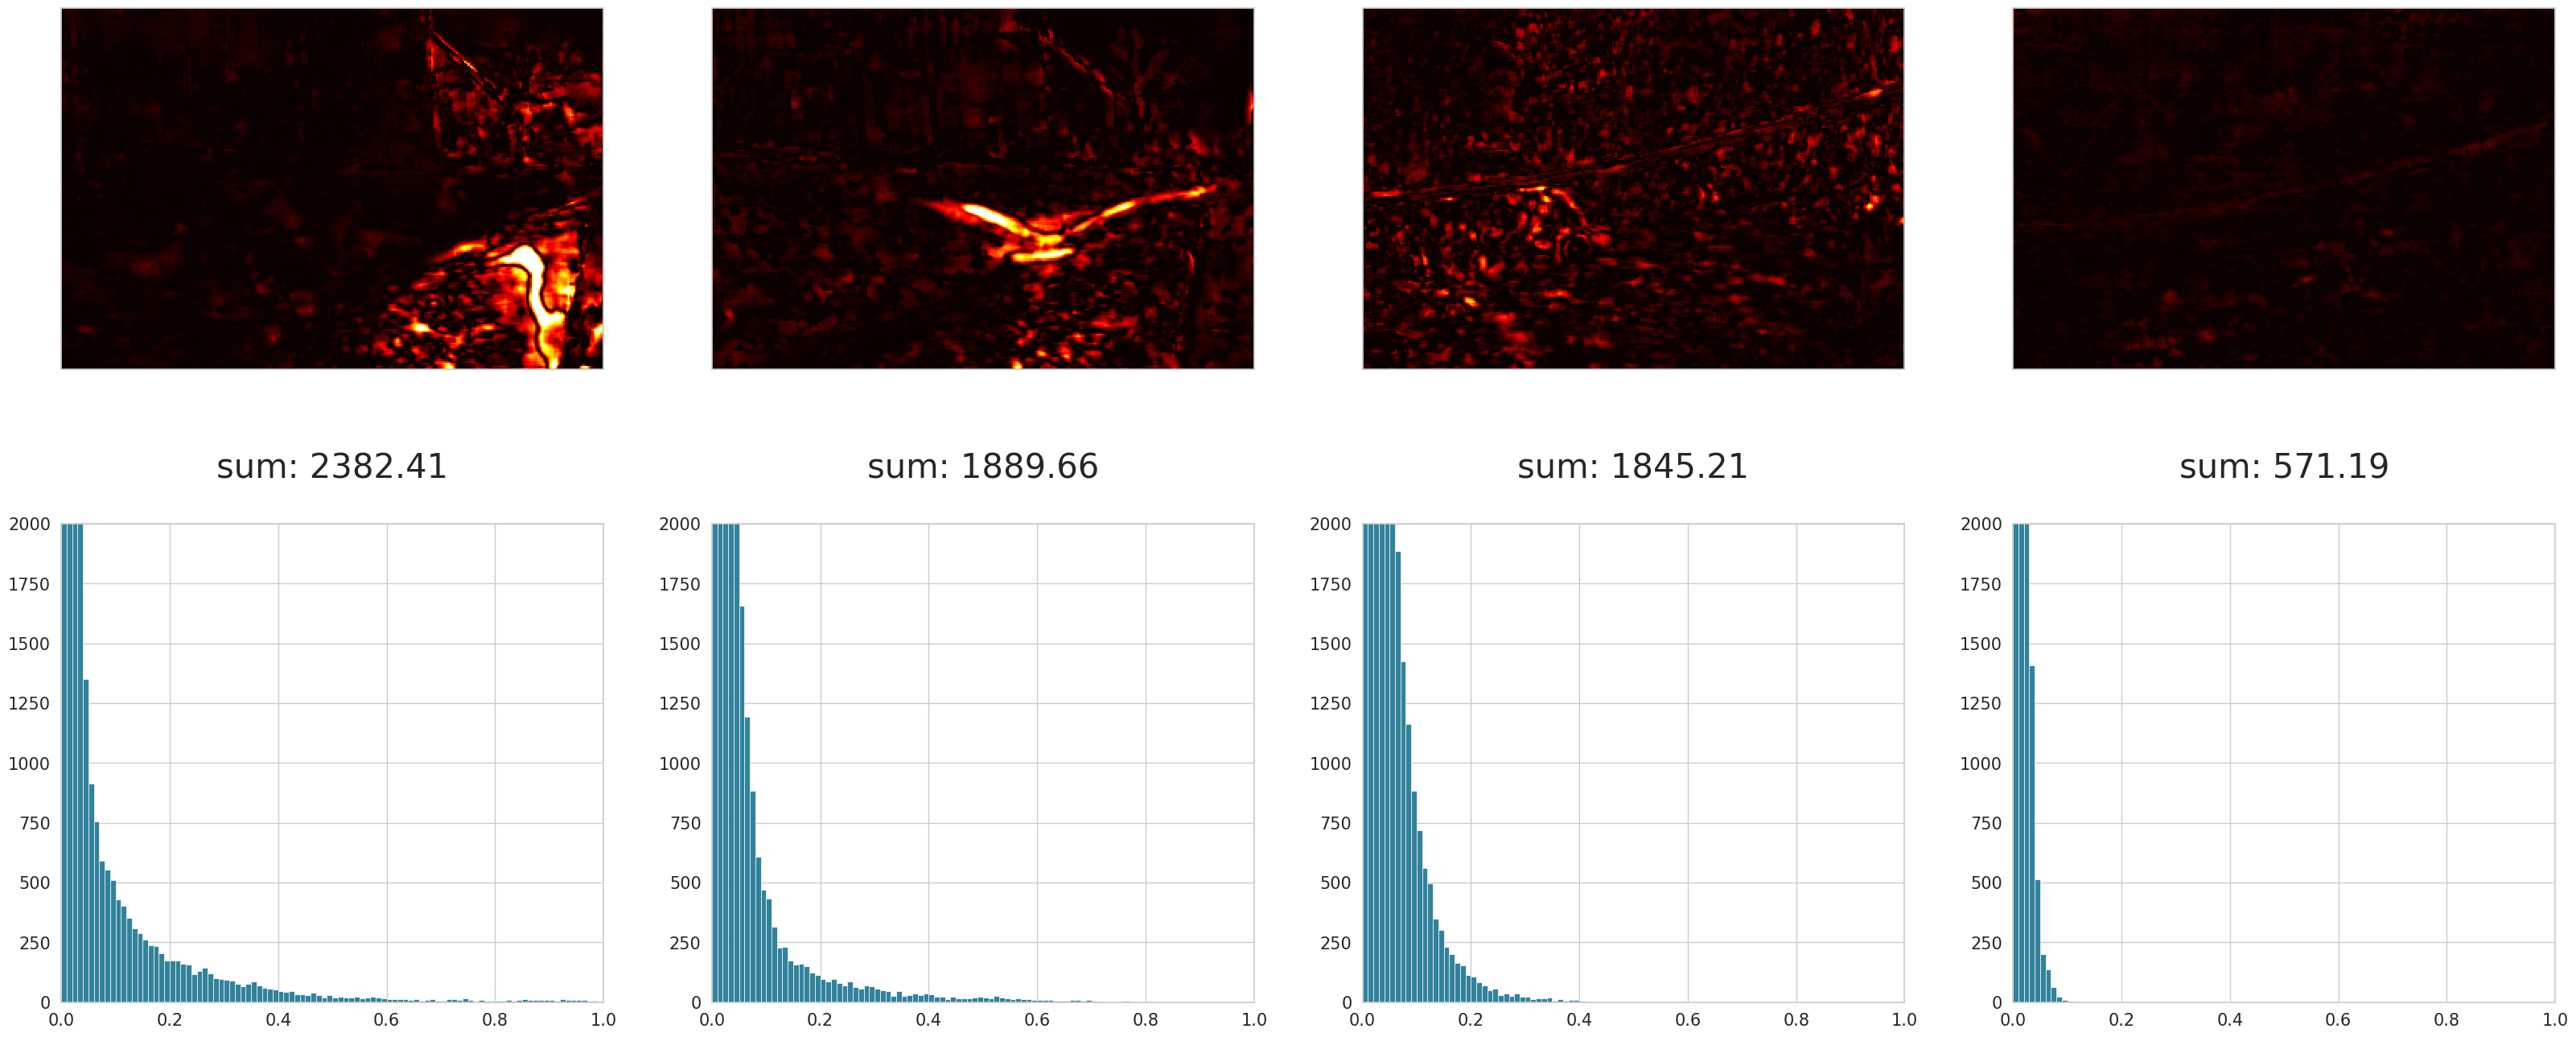

In [18]:
allPrevNextCurrImd = []
for i, (imArr, lblArr, camera, ImagePath) in enumerate(dataLoader):
            isTrainingCamera = camera in caeLoaded.hparams.cameras
            prevImg = imArr[0] #alwasy #batch_size images
            currImg = imArr[1]
            nextImg = imArr[2]

            prevPred, currPred, nextPred = [unnorm(caeLoaded(x.to(caeLoaded.device))) for x in [prevImg, currImg, nextImg]]
            allPred.append(currPred)

            prevImg, currImg, nextImg = [unnorm(x) for x in [prevImg, currImg, nextImg]]
            allImg.append(currImg)

            prevImgBlurred, currImgBlurred, nextImgBlurred = [blur.forward(x).to(prevPred.device) for x in [prevImg, currImg, nextImg]]
            
            
            prevImd, currImd, nextImd = [torch.sum(lossFn(imgBlurred, pred, reduction='none'), dim=1) for imgBlurred, pred in zip([prevImgBlurred, currImgBlurred, nextImgBlurred], [prevPred, currPred, nextPred])]
            allImd.append(currImd[0].cpu().numpy())

            prevToCurrImd = torch.clamp(torch.sub(currImd, prevImd), min= 0)
            nextToCurrImd = torch.clamp(torch.sub(currImd, nextImd), min= 0)

            prevNextCurrImd = torch.div(torch.add(prevToCurrImd, nextToCurrImd), 2)
            allPrevNextCurrImd.append(prevNextCurrImd[0].cpu().numpy())
            # prevNextCurrImdMin = torch.stack([minFilter(x, kernel_size=3) for x in prevNextCurrImd]) #TODO: evtl make this as before
            

            # prevNextCurrImdMinThresh = torch.where(prevNextCurrImdMin < params["zeroThreshold"], torch.zeros_like(prevNextCurrImdMin), prevNextCurrImdMin)
            

            # sumPrevNextCurrImdMin = torch.sum(prevNextCurrImdMinThresh, dim=(1, 2))
            # predictions = (sumPrevNextCurrImdMin> params["sumThreshold"]).to(torch.int)


plotAndHistArr(allPrevNextCurrImd, 0, 0.7)


## with minFilter

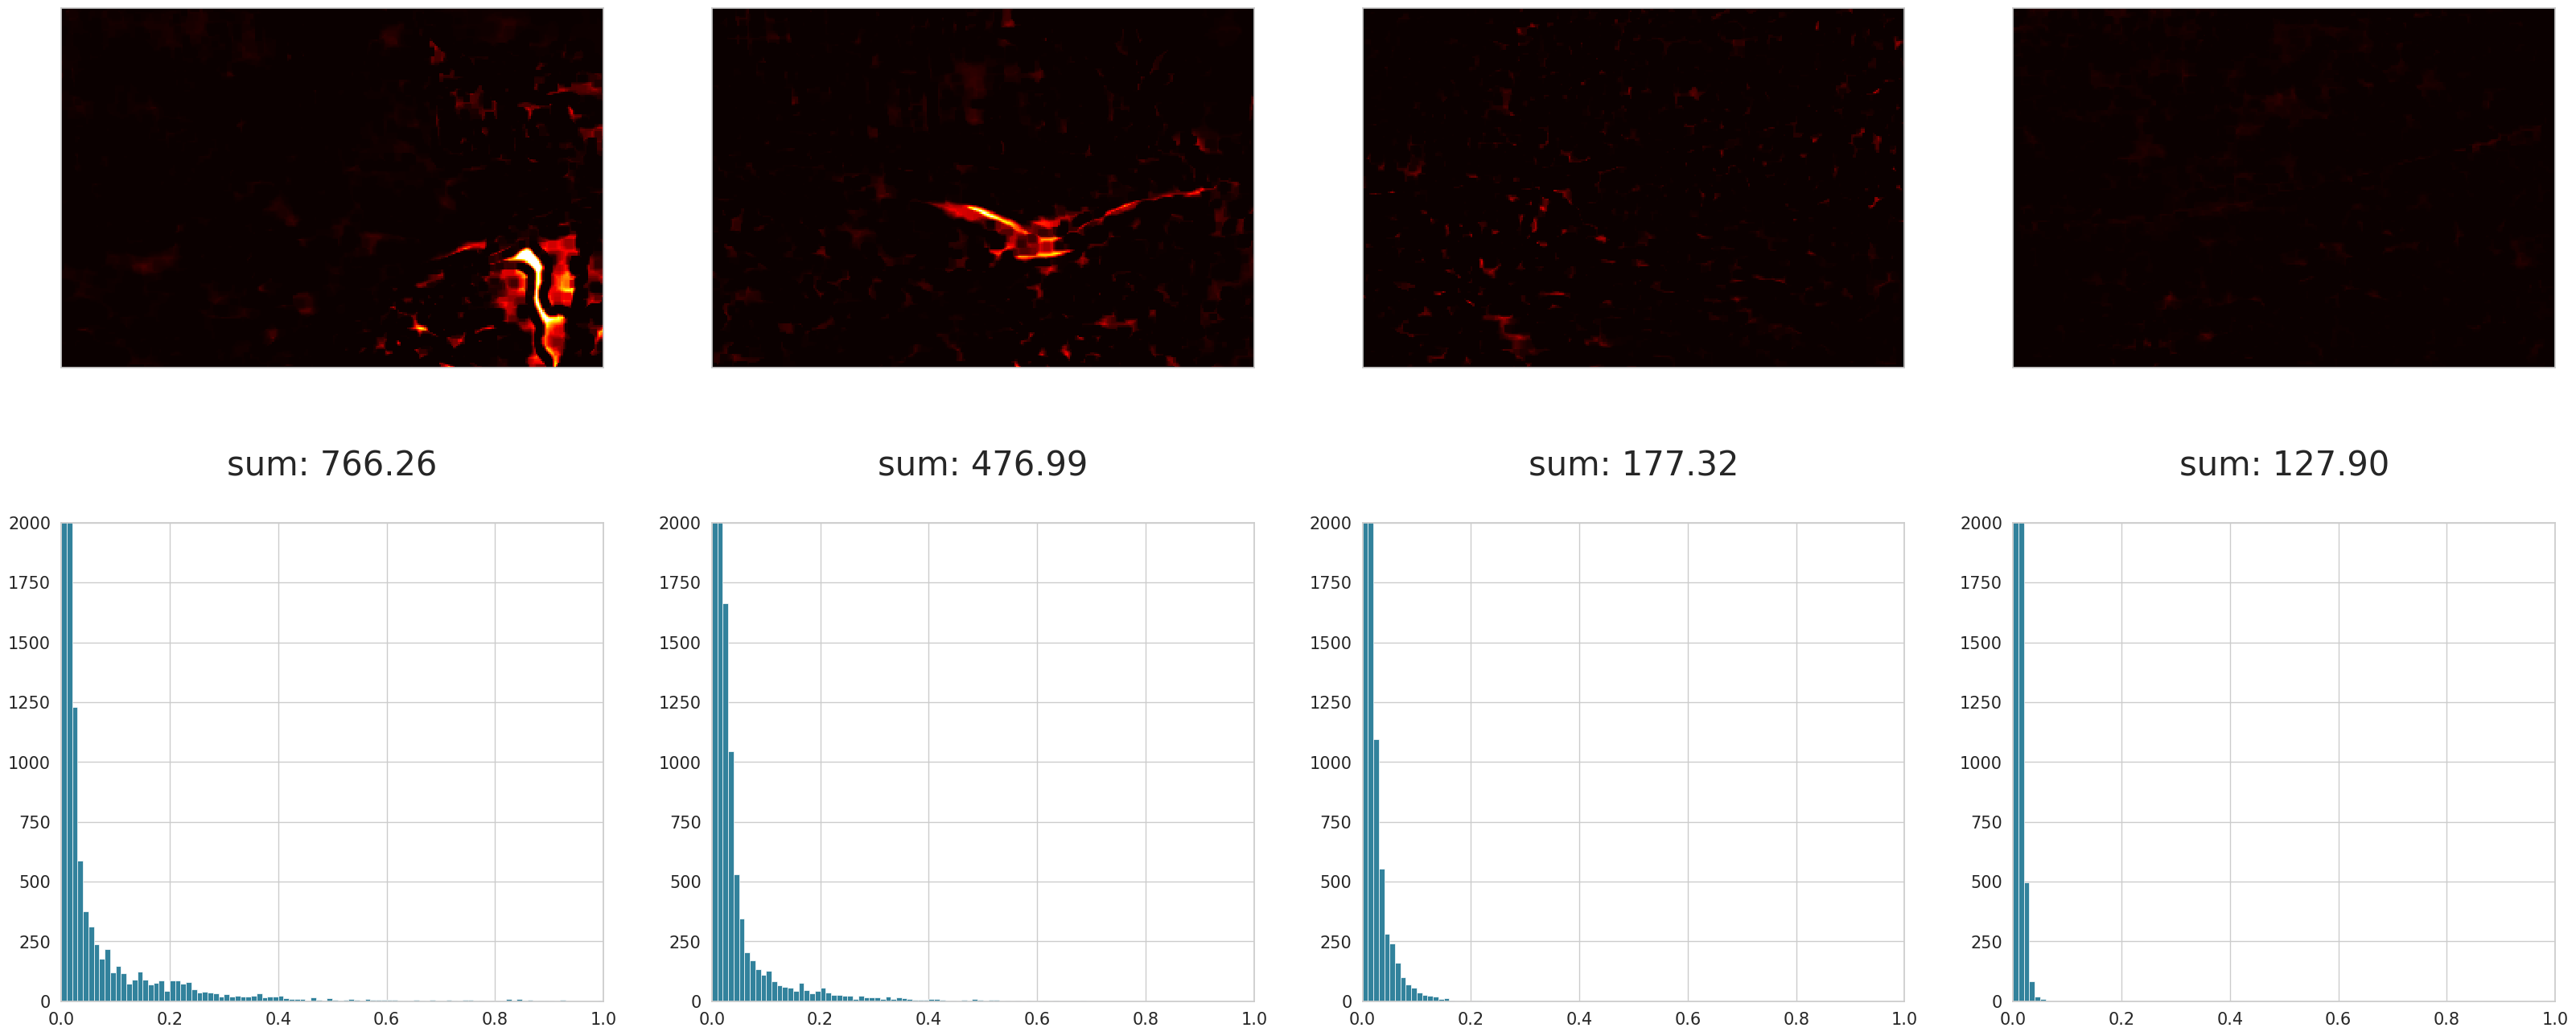

In [19]:
allPrevNextCurrImdMin = []
for i, (imArr, lblArr, camera, ImagePath) in enumerate(dataLoader):
            isTrainingCamera = camera in caeLoaded.hparams.cameras
            prevImg = imArr[0] #alwasy #batch_size images
            currImg = imArr[1]
            nextImg = imArr[2]

            prevPred, currPred, nextPred = [unnorm(caeLoaded(x.to(caeLoaded.device))) for x in [prevImg, currImg, nextImg]]

            prevImg, currImg, nextImg = [unnorm(x) for x in [prevImg, currImg, nextImg]]

            prevImgBlurred, currImgBlurred, nextImgBlurred = [blur.forward(x).to(prevPred.device) for x in [prevImg, currImg, nextImg]]
            
            
            prevImd, currImd, nextImd = [torch.sum(lossFn(imgBlurred, pred, reduction='none'), dim=1) for imgBlurred, pred in zip([prevImgBlurred, currImgBlurred, nextImgBlurred], [prevPred, currPred, nextPred])]

            prevToCurrImd = torch.clamp(torch.sub(currImd, prevImd), min= 0)
            nextToCurrImd = torch.clamp(torch.sub(currImd, nextImd), min= 0)

            prevNextCurrImd = torch.div(torch.add(prevToCurrImd, nextToCurrImd), 2)
            prevNextCurrImdMin = torch.stack([minFilter(x, kernel_size=4) for x in prevNextCurrImd]) #TODO: evtl make this as before
            allPrevNextCurrImdMin.append(prevNextCurrImdMin[0].cpu().numpy())
            

            # prevNextCurrImdMinThresh = torch.where(prevNextCurrImdMin < params["zeroThreshold"], torch.zeros_like(prevNextCurrImdMin), prevNextCurrImdMin)
            

            # sumPrevNextCurrImdMin = torch.sum(prevNextCurrImdMinThresh, dim=(1, 2))
            # predictions = (sumPrevNextCurrImdMin> params["sumThreshold"]).to(torch.int)


plotAndHistArr(allPrevNextCurrImdMin, 0, 0.7)


## with threshold

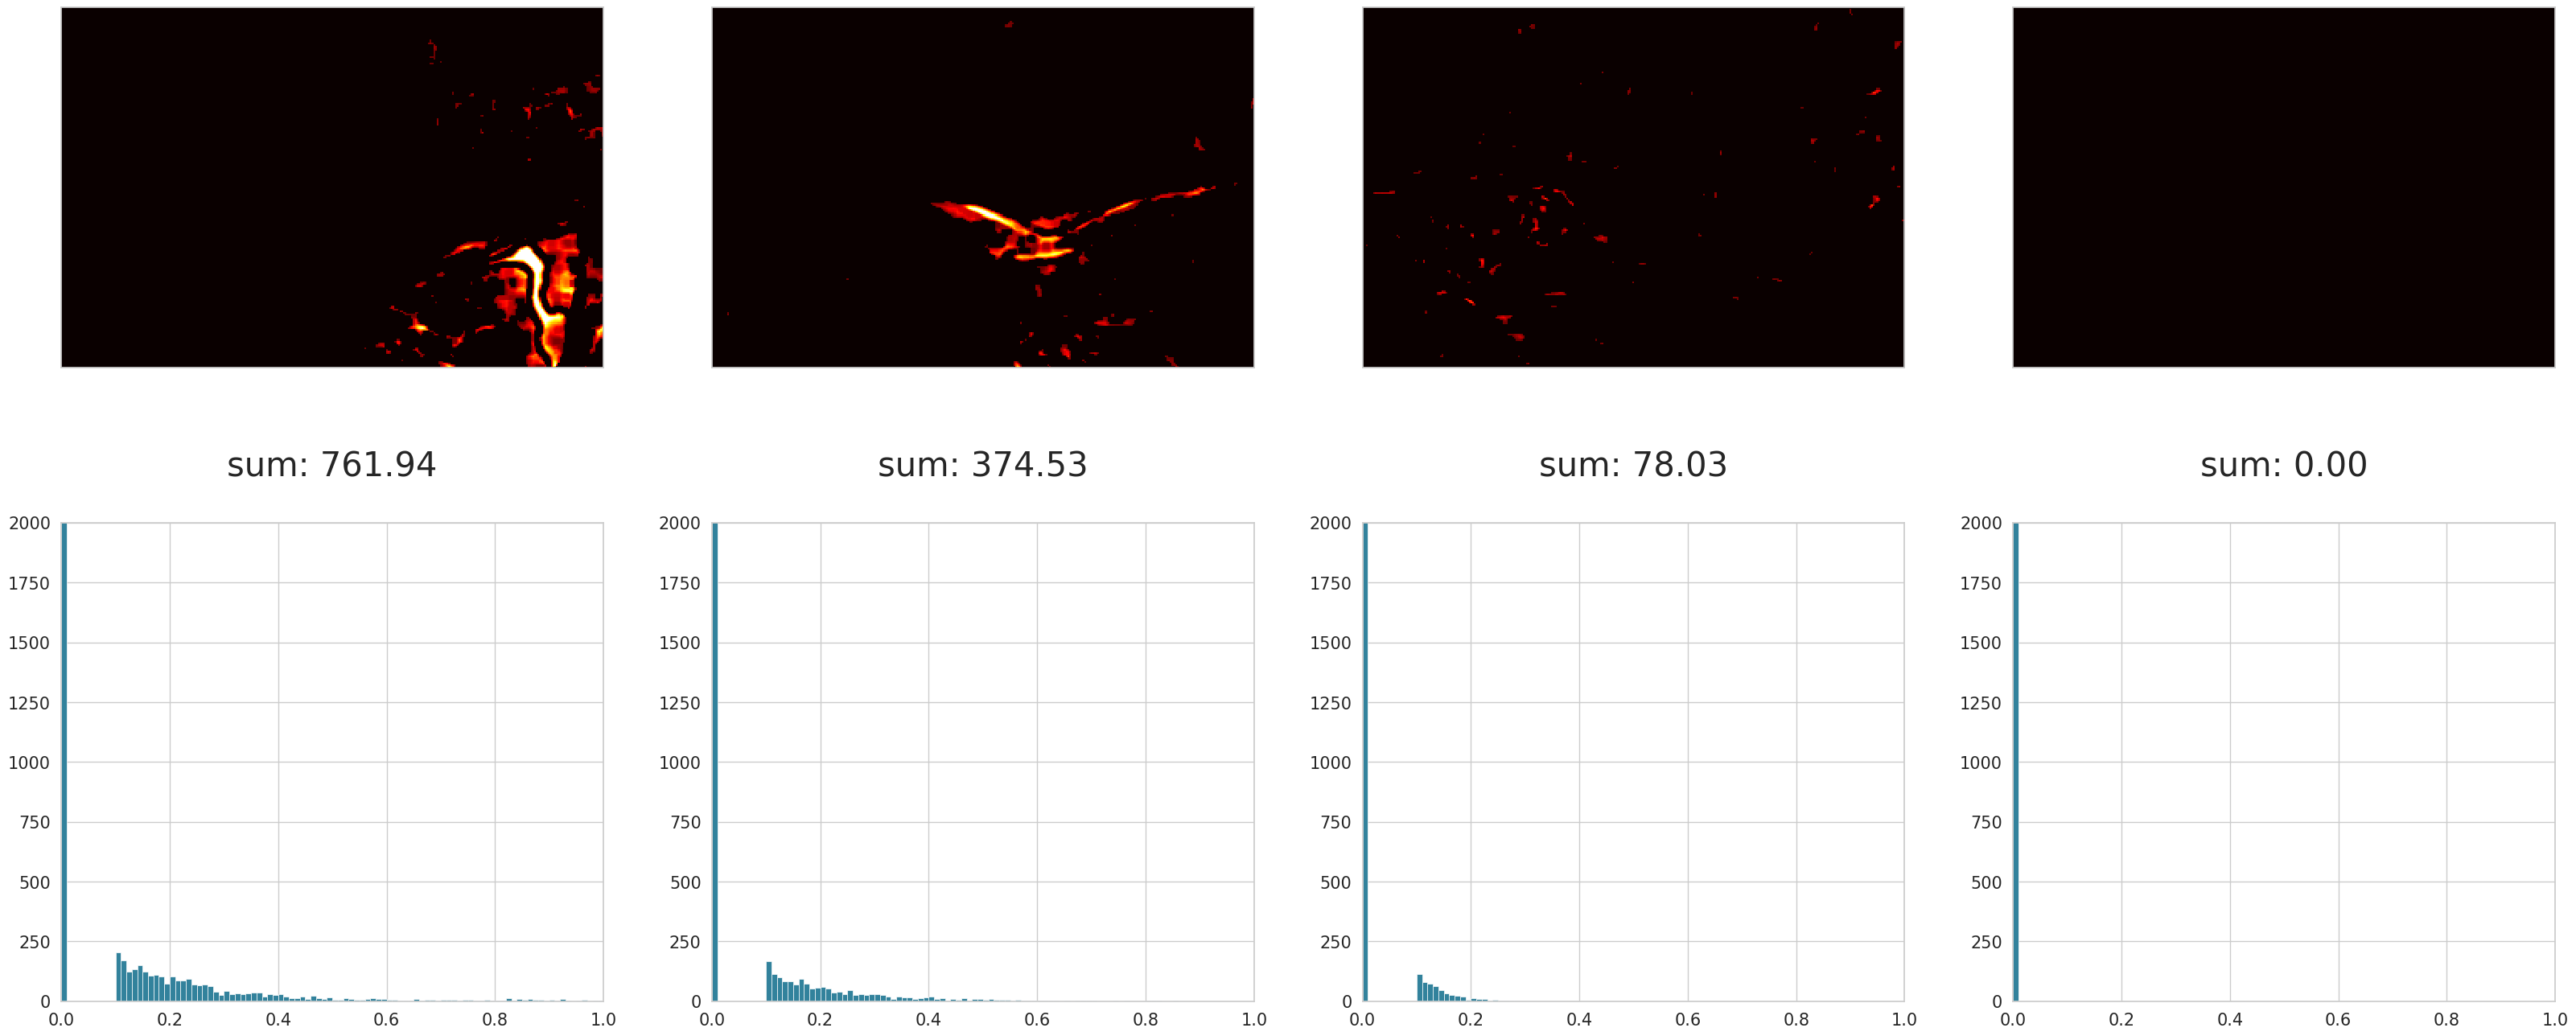

In [20]:
allPrevNextCurrImdMinThresh = []
for i, (imArr, lblArr, camera, ImagePath) in enumerate(dataLoader):
            isTrainingCamera = camera in caeLoaded.hparams.cameras
            prevImg = imArr[0] #alwasy #batch_size images
            currImg = imArr[1]
            nextImg = imArr[2]

            prevPred, currPred, nextPred = [unnorm(caeLoaded(x.to(caeLoaded.device))) for x in [prevImg, currImg, nextImg]]
            allPred.append(currPred)

            prevImg, currImg, nextImg = [unnorm(x) for x in [prevImg, currImg, nextImg]]
            allImg.append(currImg)

            prevImgBlurred, currImgBlurred, nextImgBlurred = [blur.forward(x).to(prevPred.device) for x in [prevImg, currImg, nextImg]]
            
            
            prevImd, currImd, nextImd = [torch.sum(lossFn(imgBlurred, pred, reduction='none'), dim=1) for imgBlurred, pred in zip([prevImgBlurred, currImgBlurred, nextImgBlurred], [prevPred, currPred, nextPred])]
            allImd.append(currImd[0].cpu().numpy())

            prevToCurrImd = torch.clamp(torch.sub(currImd, prevImd), min= 0)
            nextToCurrImd = torch.clamp(torch.sub(currImd, nextImd), min= 0)

            prevNextCurrImd = torch.div(torch.add(prevToCurrImd, nextToCurrImd), 2)

            prevNextCurrImdMin = torch.stack([minFilter(x, kernel_size=3) for x in prevNextCurrImd]) #TODO: evtl make this as before
            

            prevNextCurrImdMinThresh = torch.where(prevNextCurrImdMin < 0.1, torch.zeros_like(prevNextCurrImdMin), prevNextCurrImdMin)
            allPrevNextCurrImdMinThresh.append(prevNextCurrImdMinThresh[0].cpu().numpy())

            # sumPrevNextCurrImdMin = torch.sum(prevNextCurrImdMinThresh, dim=(1, 2))
            # predictions = (sumPrevNextCurrImdMin> params["sumThreshold"]).to(torch.int)


plotAndHistArr(allPrevNextCurrImdMinThresh, 0, 0.7)


In [21]:
checkPoint = '/data/tim/heronWorkspace/logs/CAEV1/version_3/checkpoints/epoch=49-step=19350.ckpt'
caeLoaded = CAEHeron.load_from_checkpoint(checkPoint, model = CAEV1)
caeLoaded.freeze()
print(caeLoaded.hparams)

dataset = DatasetThreeConsecutive(set="paper", resize_to=CAEV1.imsize, cameras=caeLoaded.hparams.cameras)
dataLoader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=4)
print(f'Length Dataset: {len(dataLoader.dataset.imagePaths)}')
unnorm = HeronImageLoader.UnNormalize()


stepY = 1
stepX = 1

blur = GaussianBlur(kernel_size=5, sigma=3)
# ssim = StructuralSimilarityIndexMeasure(reduction="none")

vmin = 0
vmax = 0.5
print(f"vmin: {vmin}, vmax: {vmax}")

print("Start Loop")

for i, (imArr, lblArr, _, _) in enumerate(dataLoader):
    lbl = lblArr[0].item()
    imgs = [x.to(caeLoaded.device) for x in imArr] #three consecutive images

    preds = [caeLoaded(x) for x in imgs] #imgs are already of shape (1, 3, 215, 323)
    
    # print(preds)

    imgsTorch = [unnorm(x.squeeze(0)) for x in imgs]
    predsTorch = [unnorm(x.squeeze(0)) for x in preds]

    imdsL1 = [heatMap(img, pred, stepY, stepX, loss_fn = F.l1_loss) for img, pred in zip(imgsTorch, predsTorch)]
    imdsMSE = [heatMap(img, pred, stepY, stepX, loss_fn = F.mse_loss) for img, pred in zip(imgsTorch, predsTorch)]

    imgs = [x.permute(1, 2, 0).cpu().numpy() for x in imgsTorch]
    preds = [x.permute(1, 2, 0).cpu().numpy() for x in predsTorch]
    imdsL1 = [x.cpu().numpy() for x in imdsL1]
    imdsMSE = [x.cpu().numpy() for x in imdsMSE]

    print("Non-Filtered Inputs:")

    # print("L1:")
    # applyFiltersAndPlotHist(imgs, preds, imdsL1, vmin, vmax, lbl)
    # print("MSE:")
    # applyFiltersAndPlotHist(imgs, preds, imdsMSE, vmin, vmax, lbl)

    print("Filtered Inputs:")
    blurredImgs = [blur.forward(x) for x in imgsTorch]

    blurredImdsL1 = [heatMap(img, pred, stepY, stepX, loss_fn = F.l1_loss) for img, pred in zip(blurredImgs, predsTorch)]
    blurredImdsMSE = [heatMap(img, pred, stepY, stepX, loss_fn = F.mse_loss) for img, pred in zip(blurredImgs, predsTorch)]
    blurredImdsL1 = [x.cpu().numpy() for x in blurredImdsL1]
    blurredImdsMSE = [x.cpu().numpy() for x in blurredImdsMSE]

    blurredImgs = [x.permute(1, 2, 0).cpu().numpy() for x in blurredImgs]

    print("L1:")
    applyFiltersAndPlotHist(blurredImgs, preds, blurredImdsL1, vmin, vmax, lbl)
    # print("MSE:")
    # applyFiltersAndPlotHist(blurredImgs, preds, blurredImdsMSE, vmin, vmax, lbl)

    
    if (i > 10):
        break


"batch_size":         16
"bottleneck":         128
"cameras":            ['NEN1', 'SBU3']
"gammaScheduler":     0.7879353477950641
"ldim":               16
"learning_rate":      0.003533238255084643
"num_workers_loader": 4
"transforms":         None
"weight_decay":       4.5387898639621974e-07
Length Dataset: 4
vmin: 0, vmax: 0.5
Start Loop


NameError: name 'heatMap' is not defined

In [ ]:
from matplotlib import rcParams
rcParams['patch.linewidth'] = 0.5

def applyFiltersAndPlotHist(imgs, preds, imds, vmin, vmax, lbl):
    f, a = plt.subplots(2,11, figsize=(110,20))

    norm = plt.Normalize(vmin=vmin, vmax=vmax)

    preDiff = imds[1] - imds[0]
    nextDiff = imds[1] - imds[2]
   
    a[0][0].imshow(imgs[1])
    a[0][0].text(-0.5,0.5, f'True: {lbl}', size=100, ha="center", color = "red", transform=a[0][0].transAxes)
    a[0][0].text(0.5,-0.2, f'current Image', size=30, ha="center", transform=a[0][0].transAxes)

    a[0][1].imshow(preds[1])
    a[0][1].text(0.5,-0.4, f'prediction\nssim img to pred: {ssim(imgs[0], preds[0], channel_axis=2, data_range=1)}', size=30, ha="center", transform=a[0][1].transAxes)

    a[0][2].imshow(np.abs(imds[1]), cmap="hot", interpolation='none', norm=norm)
    a[0][2].text(0.5,-0.5, f'difference\nimd =|currImg - pred|\nssim prev imd to curr imd:\n{ssim(imds[0], imds[1], data_range=1)}', size=30, ha="center", transform=a[0][2].transAxes)

    a[0][3].imshow(np.abs(preDiff), cmap="hot", interpolation='none', norm=norm)
    a[0][3].text(0.5,-0.2, f'|Imd - ImdPrev|', size=30, ha="center", transform=a[0][3].transAxes)

    onlyPosDiffPred = np.where(preDiff < 0, 0, preDiff)

    a[0][4].imshow(onlyPosDiffPred, cmap="hot", interpolation='none', norm=norm)
    a[0][4].text(0.5,-0.4, f'(Imd - ImdPrev)\nonly Positives', size=30, ha="center", transform=a[0][4].transAxes)
    a[1][4].hist(onlyPosDiffPred.flatten(), bins=100)

    onlyPosDiffNext = np.where(nextDiff < 0, 0, nextDiff)

    posDiffPredAndNext = np.divide(np.add(onlyPosDiffPred, onlyPosDiffNext), 2.0)
    snr = np.mean(posDiffPredAndNext)/np.std(posDiffPredAndNext)
    a[0][5].imshow(posDiffPredAndNext, cmap = "hot", interpolation='none', norm=norm)
    a[0][5].text(0.5,-0.5, f'only Positives:\n((Imd - ImdPrev) + (Imd - ImdNext)\nsum: {np.sum(posDiffPredAndNext)}\nsnr: {snr}', size=30, ha="center", transform=a[0][5].transAxes)
    a[1][5].hist(posDiffPredAndNext.flatten(), bins=100)

    posDiffPredAndNextPil = Image.fromarray(np.uint8(posDiffPredAndNext * 255))
    
    filtered = posDiffPredAndNextPil.filter(ImageFilter.MinFilter)
    filtered = np.array(filtered)/255
    a[0][6].imshow(filtered, cmap = "hot", interpolation='none', norm=norm)
    a[0][6].text(0.5,-0.4, f'MinFilter\nsum: {np.sum(filtered)}\nsnr: {np.mean(filtered)/np.std(filtered)}', size=30, ha="center", transform=a[0][6].transAxes)
    a[1][6].hist(filtered.flatten(), bins=100)

    filtered = blur.forward(posDiffPredAndNextPil)
    filtered = np.array(filtered)/255
    a[0][7].imshow(filtered, cmap = "hot", interpolation='none', norm=norm)
    a[0][7].text(0.5,-0.4, f'blurTorch\nsum: {np.sum(filtered)}\nsnr: {np.mean(filtered)/np.std(filtered)}', size=30, ha="center", transform=a[0][7].transAxes)
    a[1][7].hist(filtered.flatten(), bins=100)

    filtered = posDiffPredAndNextPil.filter(ImageFilter.SMOOTH)
    filtered = np.array(filtered)/255
    a[0][8].imshow(filtered, cmap = "hot", interpolation='none', norm=norm)
    a[0][8].text(0.5,-0.4, f'smooth\nsum: {np.sum(filtered)}\nsnr: {np.mean(filtered)/np.std(filtered)}', size=30, ha="center", transform=a[0][8].transAxes)
    a[1][8].hist(filtered.flatten(), bins=100)

    filtered = posDiffPredAndNextPil.filter(ImageFilter.MedianFilter)
    filtered = np.array(filtered)/255
    a[0][9].imshow(filtered, cmap = "hot", interpolation='none', norm=norm)
    a[0][9].text(0.5,-0.4, f'median\nsum: {np.sum(filtered)}\nsnr: {np.mean(filtered)/np.std(filtered)}', size=30, ha="center", transform=a[0][9].transAxes)
    a[1][9].hist(filtered.flatten(), bins=100)
    
    filtered = posDiffPredAndNextPil.filter(ImageFilter.MinFilter)
    filtered = np.array(filtered)/255
    filtered = np.where(posDiffPredAndNext < 0.2, 0, posDiffPredAndNext)
    normMinFilter = plt.Normalize(vmin=0, vmax=vmax/2)
    a[0][10].imshow(filtered, cmap = "hot", interpolation='none', norm=normMinFilter)
    a[0][10].text(0.5,-0.4, f'cutoff 0.3 * max von minFilter\nsum: {np.sum(filtered)}\nsnr: {np.mean(filtered)/np.std(filtered)}', size=30, ha="center", transform=a[0][10].transAxes)
    a[1][10].hist(filtered.flatten(), bins=100)

    for i in range(0, 10):
        # a[1][i].set_yscale('log')
        a[1][i].set_ylim([0,250])
        a[1][i].set_xlim([0,1])
       
        # a[1][i].set_xlim([0,100])
    a[1][10].set_xlim([0.01, 0.7])
    a[1][10].set_ylim([0,100])

    for i in range(0, 11):
        a[0, i].grid(False)
    plt.show()

In [ ]:
def heatMap(before: torch.Tensor, after: torch.Tensor, stepY, stepX, loss_fn = F.mse_loss):
    heatMap = []
    for i in range(0, before.shape[-2]-stepY+1, stepY):
        row = []
        for j in range(0, before.shape[-1]-stepX+1, stepX):
            row.append(loss_fn(before[:, i:i+stepY, j:j+stepX], after[:, i:i+stepY, j:j+stepX]).item())
        heatMap.append(row)
    return torch.tensor(heatMap).type_as(before)

In [ ]:
checkPoint = '/data/tim/heronWorkspace/logs/CAEV1/version_3/checkpoints/epoch=49-step=19350.ckpt'
caeLoaded = CAEHeron.load_from_checkpoint(checkPoint, model = CAEV1)
caeLoaded.freeze()
print(caeLoaded.hparams)

dataset = DatasetThreeConsecutive(set="paper", resize_to=CAEV1.imsize, cameras=caeLoaded.hparams.cameras)
dataLoader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=4)
print(f'Length Dataset: {len(dataLoader.dataset.imagePaths)}')
unnorm = HeronImageLoader.UnNormalize()


stepY = 1
stepX = 1

blur = GaussianBlur(kernel_size=5, sigma=3)
# ssim = StructuralSimilarityIndexMeasure(reduction="none")

vmin = 0
vmax = 0.5
print(f"vmin: {vmin}, vmax: {vmax}")

print("Start Loop")

for i, (imArr, lblArr, _, _) in enumerate(dataLoader):
    lbl = lblArr[0].item()
    imgs = [x.to(caeLoaded.device) for x in imArr] #three consecutive images

    preds = [caeLoaded(x) for x in imgs] #imgs are already of shape (1, 3, 215, 323)
    
    # print(preds)

    imgsTorch = [unnorm(x.squeeze(0)) for x in imgs]
    predsTorch = [unnorm(x.squeeze(0)) for x in preds]

    imdsL1 = [heatMap(img, pred, stepY, stepX, loss_fn = F.l1_loss) for img, pred in zip(imgsTorch, predsTorch)]
    imdsMSE = [heatMap(img, pred, stepY, stepX, loss_fn = F.mse_loss) for img, pred in zip(imgsTorch, predsTorch)]

    imgs = [x.permute(1, 2, 0).cpu().numpy() for x in imgsTorch]
    preds = [x.permute(1, 2, 0).cpu().numpy() for x in predsTorch]
    imdsL1 = [x.cpu().numpy() for x in imdsL1]
    imdsMSE = [x.cpu().numpy() for x in imdsMSE]

    print("Non-Filtered Inputs:")

    # print("L1:")
    # applyFiltersAndPlotHist(imgs, preds, imdsL1, vmin, vmax, lbl)
    # print("MSE:")
    # applyFiltersAndPlotHist(imgs, preds, imdsMSE, vmin, vmax, lbl)

    print("Filtered Inputs:")
    blurredImgs = [blur.forward(x) for x in imgsTorch]

    blurredImdsL1 = [heatMap(img, pred, stepY, stepX, loss_fn = F.l1_loss) for img, pred in zip(blurredImgs, predsTorch)]
    blurredImdsMSE = [heatMap(img, pred, stepY, stepX, loss_fn = F.mse_loss) for img, pred in zip(blurredImgs, predsTorch)]
    blurredImdsL1 = [x.cpu().numpy() for x in blurredImdsL1]
    blurredImdsMSE = [x.cpu().numpy() for x in blurredImdsMSE]

    blurredImgs = [x.permute(1, 2, 0).cpu().numpy() for x in blurredImgs]

    print("L1:")
    applyFiltersAndPlotHist(blurredImgs, preds, blurredImdsL1, vmin, vmax, lbl)
    # print("MSE:")
    # applyFiltersAndPlotHist(blurredImgs, preds, blurredImdsMSE, vmin, vmax, lbl)

    
    if (i > 10):
        break


In [ ]:
for i, (imArr, lblArr, _, _) in enumerate(dataLoader):
    plt.imshow(imArr[0].item().permute(1, 2, 0).cpu().numpy())
    plt.show()

In [7]:
df = pd.read_csv("/data/tim/heronWorkspace/manuallyClassified/manuallyClassifiedNEN1.csv")
df[df["ValidationValue"] == 2]["ImagePath"].to_list()[:10]

['2017_NEN1_03200419',
 '2017_NEN1_04050024',
 '2017_NEN1_03220623',
 '2017_NEN1_03200432',
 '2017_NEN1_07170789',
 '2017_NEN1_03280207',
 '2017_NEN1_01310504',
 '2017_NEN1_07140519',
 '2017_NEN1_02260016',
 '2017_NEN1_02110554']